<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/DataFrameMakerCRY5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)


import matplotlib.pyplot as plt
%pip -q install uproot
%pip -q install --upgrade tables
import uproot
import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Copy files from mu2egpvm machines

In [15]:
if False:
  import os
  os.environ['KRB5_CONFIG'] = 'krb5.conf'

  !apt-get -qq install krb5-user > /dev/null
  !wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf

  !kinit oksuzian@FNAL.GOV
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/mu2e/data/users/oksuzian/nts.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0.tka .
  !cp nts.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0.tka drive/MyDrive/root_files_cry5/

# Init and define function

In [6]:
#f='drive/MyDrive/root_files_cry5/trkana.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0_1.root'
#trkana = uproot.open(f+":TrkAnaNeg/trkana")
#trkana.keys()

In [7]:
DATASET='CRY5mixed'

if DATASET=='CRY5mixed':
  h5file='drive/MyDrive/root_files_cry5/trk.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0.h5'
  files_root={  
      'drive/MyDrive/root_files_cry5/trkana.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0_1.root' : [17000, 1]               
#    'drive/MyDrive/root_files_cry5/nts.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0.tka': [17000, 1]
    }
elif DATASET=='CE1B':
  h5file='drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix1BBSignal.MDC2020r_perfect_v1_0.h5'
  files_root={                  
    'drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix1BBSignal.MDC2020r_perfect_v1_0.root': [17000, -1],
  }
elif DATASET=='CE2B':
  h5file='drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix2BBSignal.MDC2020r_perfect_v1_0.h5'
  files_root={                  
    'drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix2BBSignal.MDC2020r_perfect_v1_0.root': [17000, -1],
  }
else:
  raise ValueError('Unknown dataset')

In [8]:
def make_df(trkana, tag_high, lyield):

  df = trkana.arrays(filter_name=['evtinfo.*', 'evtinfomc.*', 'de.*', 'deent*', 'demc.*', 'demcgen.*', 'demcpri.*', 'ue.*', 'crvsummary.*', 'crvsummarymc.*', 'dequal*', 'detrkpid*', 'debestcrv./*', 'debestcrvmc./*'],library="pd")
  df.columns = df.columns.str.replace('.', '_')
  df.columns = df.columns.str.replace('__', '_')
  df.columns = df.columns.str.replace('_fCoordinates_f', '')
  df["deent_mom"] = pow(pow(df["deent_momX"],2) + pow(df["deent_momY"],2) + pow(df["deent_momZ"],2),0.5)
  df["demcpri_mom"] = pow(pow(df["demcpri_momX"],2) + pow(df["demcpri_momY"],2) + pow(df["demcpri_momZ"],2),0.5)

  df['is_high'] = tag_high
  df['lyield'] = int(lyield)
  df["debestcrv_dT"] = df["debestcrv_timeWindowStart"] - df["de_t0"]
  df["debestcrv_dTe"] = df["debestcrv_timeWindowEnd"] - df["de_t0"]
  df = df.fillna(-999999)
  return df

In [9]:
 def combine_df(files):
    
  df = pd.DataFrame()
  for f in files:
      print("Reading file", f, files[f][0], files[f][1])
      trkana = uproot.open(f+":TrkAnaNeg/trkana")
      df_ = make_df(trkana, files[f][1], files[f][0])
      df_ = df_.filter(regex=var_str)
      df = df.append(df_)
  df = df.loc[:,~df.columns.duplicated()]  # delete duplicate colummns
  return df   

#Variables list to save in df

In [10]:
var_list=[
 'evtinfo_eventid',
 'evtinfo_subrunid',
 'evtinfomc_nprotons',
 'de_status',
 'de_pdg',
 'de_nhits',
 'de_t0',
 'deent_mom',
 'deent_d0',
 'deent_p0',
 'deent_z0',
 'deent_td',
 'dequal_TrkPID',
 'dequal_TrkQual',
 'detrkpid',
 'demc_pdg',
 'demc_gen',
 'demcgen_pdg',
 'demcgen_gen',
 'demcgen_posx',
 'demcgen_posy',
 'demcgen_posz',
 'demcgen_momx',
 'demcgen_momy',
 'demcgen_momz',
 'demcpri_posX',
 'demcpri_posY',
 'demcpri_posZ',
 'demcpri_posZ',
 'demcpri_pdg',
 'demcpri_mom',
 'trigbits',
 'ue_status',
 'ue_nhits',
 '_totalPEs',
 '_nHitCounters',
 '_totalEnergyDeposited',
 '_x',
 '_y',
 '_z',
 '_pdgId',
 '_crvSectorNumber',
 '_crvSectorType',
 'crvsummary_totalPEs',
 'crvsummary_nHitCounters',
 'crvsummarymc_totalEnergyDeposited',
 'crvsummarymc_x',
 'crvsummarymc_y',
 'crvsummarymc_z',
 'crvsummarymc_pdgId',
 'crvsummarymc_crvSectorNumber',
 'crvsummarymc_crvSectorType',
 'debestcrv_crvSectorType',
 'debestcrv_x',
 'debestcrv_y',
 'debestcrv_z',
 'debestcrv_PEs',
 'debestcrv_timeWindowStart',
 'debestcrv_timeWindowEnd',
 'debestcrv_angle',
 'debestcrv_nCoincidenceHits',
 'debestcrv_nCoincidenceLayers',
 'debestcrvmc',
 'bestcrv',
 'is_high',
 'lyield',
 'debestcrv_dT',
 'debestcrv_dTe',
 'deent_maxr',
 'is_triggered']

var_str='('
for var in var_list:
  if var == "detrkpid":
    var_str=var_str+var+'|'
  elif var == 'debestcrvmc':
    var_str=var_str+var+'|'
  else: 
    var_str=var_str+var+'$|'

var_str=var_str[:-1]+')'

# Save dataframe

In [11]:
df = combine_df(files_root)
df.to_hdf(h5file, key=DATASET)

Reading file drive/MyDrive/root_files_cry5/trkana.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0_1.root 17000 1


/usr/local/lib/python3.7/dist-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, 

#Load dataframe

In [12]:
df = pd.read_hdf(h5file, mode='r', key=DATASET).query('lyield==17000')

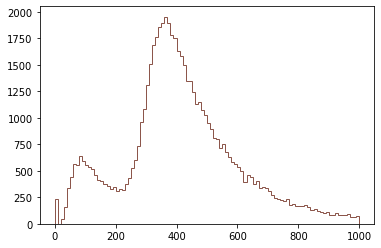

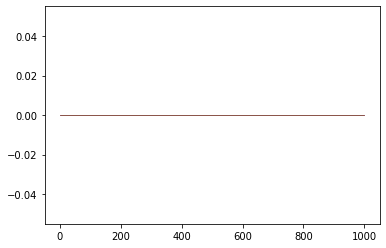

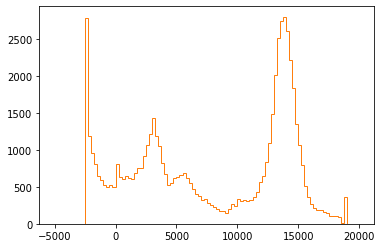

In [13]:
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==1 & lyield==%i' % l)['debestcrv_PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==0 & lyield==%i' % l)['debestcrv_PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
plt.hist(df.query('is_high==0 & lyield==%i' % 17000)['debestcrvmc_z'], bins=100, range=(-5000, 20000), histtype='step');
plt.hist(df.query('is_high==1 & lyield==%i' % 17000)['debestcrvmc_z'], bins=100, range=(-5000, 20000), histtype='step');

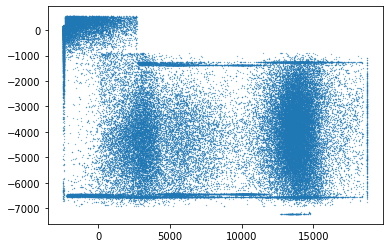

In [14]:
cut_tmp = 'lyield==%i' % 17000
plt.plot(df.query(cut_tmp)['debestcrvmc_z'], df.query(cut_tmp)['debestcrvmc_x'], '.', markersize=0.5);